# The KS score and Youden's J

##  Why KS?

The **Kolmogorov-Smirnov (KS) score** is a commonly used metric for credit models. 
It is a measure of the difference between class 1 and class 0, and is created from the distance between their respective score distributions.

It is not the best metric - in fact, we will see that it only captures a portion of the behavior of the ROC AUC. We report it here because it is so standard in the Brazilian credit industry.

## Definition

Recall the setup we had for ROC analysis. Let $f$ be a score function. We defined

$$Z_1 = (f(X)|Y=1),\qquad Z_0 = (f(X)|Y=0)$$

as the scores for each class. These components were important, for instance when demonstrating the probabilistic interpretation of the ROC AUC as 

$$\mathrm{AUC} = \mathbb P (Z_1 \geq Z_0).$$

Now, let 

$$F_1(\lambda) = \mathbb P(Z_1 \leq \lambda), \qquad F_0(\lambda) = \mathbb P(Z_0 \leq \lambda)$$

denote the CDFs for both variables.

**Def [KS score]**. Consider the standard binary classification problem, where $(X,Y)$ are jointly distributed, $X$ taking values in $\mathbb R^n$ and $Y$ in $\{0,1\}$. Let $f: \mathbb R^n \to [0,1]$ be a score function, and define $Z_0, Z_1$ as above, as well as their CDFs $F_0$ and $F_1$. The **KS score** is the value

$$\boxed{\mathrm{KS} = \sup_{\lambda \in [0,1]} |F_0(\lambda) - F_1(\lambda)|}$$

where $\sup$ denotes the supremum.

Notes:
* The KS score is based on the *KS statistic*, which is an analogous quantity defined for a theoretical CDF $F$ and its empirical estimator $F_n$ based on a sample of $n$ points.
* In a well-built classification problem, $F_0 \geq F_1$ always, and we do not need to write the absolute value.
* Since both $F_0$ and $F_1$ are bounded in $[0,1]$, KS also takes values in between 0 (equal distributions) and 1 (completely separated distributions). Therefore, **good models will have high KS values**.
    

The KS score is very used in credit models, and particularly used in Brazilian markets as the industry benchmark.

## Calculating the KS score

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


def make_balanced_problem():
    X, y = make_classification(n_samples=5000, n_features=10, n_informative=8, n_redundant=1, n_repeated=1, 
                               random_state=10) 
    return X, y

def solve_balanced_problem(X, y, model_choice='logistic'):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

    if model_choice == 'logistic':
        model = LogisticRegression()
    else:
        model = RandomForestClassifier()
        
    model.fit(X_train, y_train)
    return X_train, X_test, y_train, y_test, model

def make_imbalanced_problem(imb=0.99):
    X, y = make_classification(n_samples=20000, n_features=10, n_informative=8, n_redundant=1, n_repeated=1, 
                               random_state=10,
                               weights=(imb,)) 
    return X, y

In [2]:
X, y = make_balanced_problem()
_, X_test, _, y_test, model = solve_balanced_problem(X, y)
y_test_pred = model.predict_proba(X_test)[:,1]

In [3]:
fpr, tpr, thresh = roc_curve(y_test, y_test_pred)

We will calculate the KS score in two ways: first using the `scipy` implementation, then sanity-checking by building from scratch a CDF estimator and maximizing the differenc between the CDFs.

In [4]:
def ks_score(y_true, y_probs):
    from scipy.stats import ks_2samp
    z1 = y_probs[y_true==1]
    z0 = y_probs[y_true==0]
    ks = ks_2samp(z1, z0).statistic
    return ks

In [5]:
print("KS = {0:.2f}".format(ks_score(y_test, y_test_pred)))

KS = 0.38


Now sanity checking:

In [6]:
def cdf(x: np.array):
    """
    Approximate a random variable's CDF via linear interpolation
    of the empirical CDF points
    """
    from scipy.interpolate import interp1d
    
    y = np.arange(len(x))
    y = y/y.max()
    
    order_x = np.sort(x)
    
    f = interp1d(order_x,y, bounds_error=False, fill_value=1)
    a, b = order_x[0], order_x[1]

    def interpolated(p):
        return np.where(p <= a, 0, f(p))

    return interpolated

def maximize(func, initial_guess=0.5):
    from scipy.optimize import fmin
    min_x = fmin(lambda x: -func(x), initial_guess, full_output=True, disp=False)
    x_opt, max_x = min_x[0], -(min_x[1])
    return x_opt, max_x

In [7]:
# checking by hand
z0, z1 = y_test_pred[y_test==0], y_test_pred[y_test==1]
f0, f1 = cdf(z0), cdf(z1)
x_opt, ks_check = maximize(lambda x: np.abs(f0(x) - f1(x)))

In [8]:
print("KS (check) = {0:.2f}".format(ks_check))

KS (check) = 0.38


So the original implementation works and we may use it going forward. Let us plot the resulting curves:

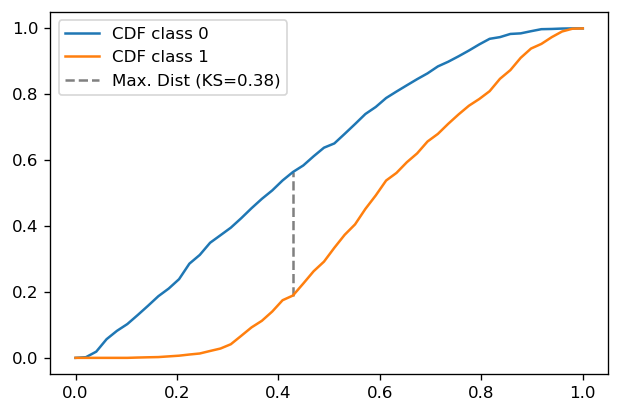

In [9]:
xx = np.linspace(0,1)
plt.plot(xx, f0(xx), label='CDF class 0')
plt.plot(xx, f1(xx), label='CDF class 1')
plt.vlines(x_opt, f1(x_opt), f0(x_opt), linestyle='--', color='gray', label="Max. Dist (KS={0:.2f})".format(ks_check))
plt.legend()
plt.show()

## The connection between KS and the ROC curve

Recall that the ROC curve has axes

$$x(\lambda) \equiv \mathrm{FPR}(\lambda) = \mathbb P (f(X) \geq \lambda | Y=0) = \mathbb P(Z_0 \geq \lambda)$$
$$y(\lambda) \equiv \mathrm{TPR}(\lambda) = \mathbb P (f(X) \geq \lambda | Y=1) = \mathbb P(Z_1 \geq \lambda)$$

Since $\mathbb P(Z_0 \geq \lambda) = 1 - \mathbb P(Z_0 \leq \lambda) = 1 - F_0(\lambda)$ (and similarly for $F_1$), we may then write the KS score as

$$\begin{align*}
\mathrm{KS} &= \sup_{\lambda \in [0,1]} |F_0(\lambda) - F_1(\lambda)|\\
            &= \sup_{\lambda \in [0,1]} (y(\lambda) - x(\lambda))
\end{align*}$$

We define **Youden's J statistic** as 

$$\boxed{J(\lambda) := y(\lambda) - x(\lambda) = \mathrm{TPR}(\lambda) - \mathrm{FPR}(\lambda)}$$

so that 

$$\mathrm{KS} = \sup_{\lambda \in [0,1]} J(\lambda)$$

Note: one will usually see the definition of $J$ as being $J = \mathrm{sensitivity + specificity} -1$, where sensitivity is another name for TPR and specificity is $1 - \mathrm{FPR}$. 

There is an intricate visual connection between the ROC curve and the KS metric. **Notice how $y-x$ is simply the vertical distance, in the ROC plane**, between the ROC curve and the 45 degree diagonal, as we exemplify below:

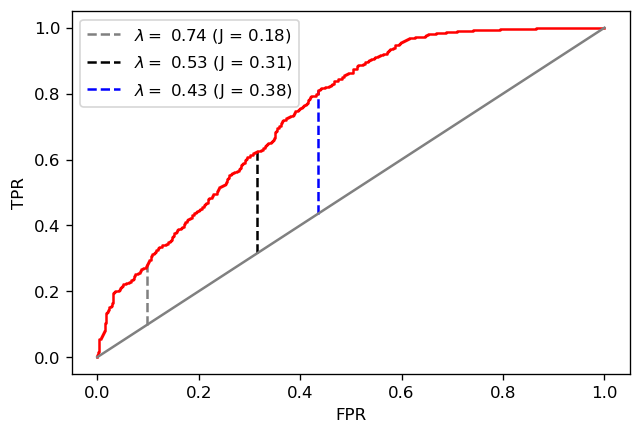

In [11]:
plt.plot(fpr, tpr, color='red')
plt.plot([0,1], color='gray')

for index, color in zip([100, 300, 412], ['gray', 'black', 'blue']):
    x_, y_ = fpr[index], tpr[index]
    plt.vlines(x_, ymin=x_, ymax=y_, linestyle='--',
            color=color,
            label='$\lambda = $ {0:.2f} (J = {1:.2f})'.format(thresh[index], y_-x_))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

Notice that our optimal value for $J$ (which is of course the KS score) is obtained for $\lambda = 0.43$. This is, in a sense, an optimal threshold choice for the problem at hand (since it is where the separation between class scores is maximal).

It turns out that one can infer this value for $\lambda$ from a geometrical property of the ROC curve:

**Proposition**. Let $\lambda \mapsto (x(\lambda), y(\lambda))$ be the ROC curve. Assume that $\lambda \mapsto x(\lambda)$ is invertible, so that $y$ can also be expressed as a function of $x$. With no loss of generality assume $x \mapsto y(x)$ is *concave* and once differentiable.

Then, the value $\lambda = \lambda^*$ satisfying the KS condition

$$\lambda^* = \mathrm{arg}\max_{\lambda \in [0,1]} J(\lambda)$$

is such that

$$\left.\frac{dy}{dx}\right|_{\lambda=\lambda^*} = 1.$$

*Proof*: since $J(\lambda) = y(\lambda) - x(\lambda)$, one can write

$$\frac{dJ}{d\lambda} = \frac{dy}{d\lambda} - \frac{dx}{d\lambda} = \frac{dx}{d\lambda} \left(\frac{dy}{dx} - 1\right)$$

Under the assumption of $\lambda \mapsto x(\lambda)$ invertible, $dx/d\lambda$ is never zero and thus $dy/dx = 1$ as claimed.$\Box$

To see that this value is unique, it is easier to work with a rotated version of the ROC curve. We rotate the whole plane 45 degrees clockwise, in such a way that the 45 degree diagonal is now on the $x$ axis. This can be achieved via the rotation matrix

$$R = \frac{1}{\sqrt 2}\begin{pmatrix}
1 & 1\\
-1 & 1
\end{pmatrix}$$

The new coordinates are

$$x'= \frac{y+x}{\sqrt 2}\;\; \in [0,\sqrt 2], \qquad y'= \frac{y - x}{\sqrt 2}\;\; \in [0, 1/\sqrt 2]$$

Notice that, up to a constant, $y'$ is equal to $J$. Finding its maximum (where $dy'/dx' = 0$) is equivalent to finding a 45 degree-slope point in $(x,y)$ coordinates, and also equivalent to finding the maximum of $J$, which happens at $\lambda^*$! Finally, if the ROC is concave (and fixed at $(0,0)$ and $(1,1)$) then its rotated version will also be concave, with a unique maximum.

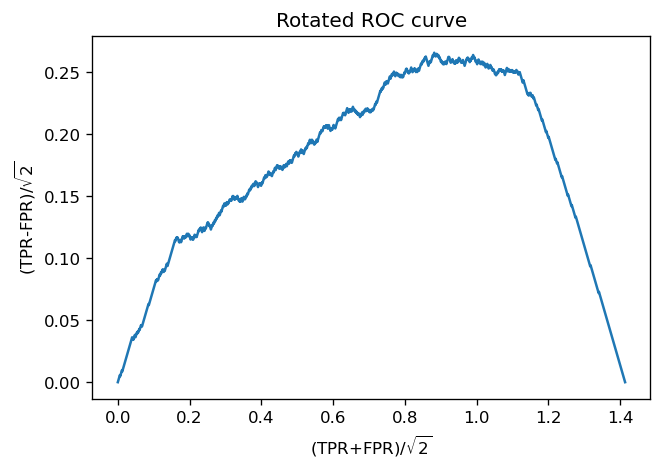

In [12]:
# How does the rotated version look like?
x_prime = (fpr + tpr)/np.sqrt(2)
y_prime = (tpr - fpr)/np.sqrt(2)
plt.title("Rotated ROC curve")
plt.plot(x_prime, y_prime)
plt.xlabel("(TPR+FPR)/$\sqrt{2}$"); plt.ylabel("(TPR-FPR)/$\sqrt{2}$")
plt.show()

Technical notes:
* Empirical ROC curves need not be concave. The argument still applies, since we can always build the convex hull (which is really a misnomer - it is a concave hull) making it concave. 

* Empirical ROC curves need not be differentiable. However, their convex hull is piecewise differentiable in the form of line segments. Then, the argument still applies, since the convex hull admits a [subderivative](https://en.wikipedia.org/wiki/Subderivative).

## What about KS and the ROC AUC?

As we we have just seen, there is an intimate connection between the ROC curve and the KS score. One might wonder if there is a connection between the ROC *AUC* and the KS scores, as two scalars that indicate model performance.

It turns out that **there is a connection, although not a super useful one**: the KS score is (an affine function of) the ROC AUC of the classifier constructed via the below procedure.

1. For your original score $f(x)$, find the optimal $\lambda^*$ as that for which $J(\lambda^*) = \mathrm{KS}$
2. Build a single-point classifier: 

$$g(x) = \begin{cases}
1 & \mbox{ if } f(x) \geq \lambda^*\\
0 & \mbox{ if } f(x) < \lambda^*
\end{cases}$$

3. Then, 

    $$\mathrm{AUC}[g] = \frac{\mathrm{KS}[f]+1}{2}$$
    
    and in particular, $\mathrm{KS}[f] = \mathrm{Gini}[g]$.

Let us build it. 

In [13]:
def single_point_classifier(y_true, y_probs):

    from sklearn.metrics import roc_curve, roc_auc_score
    # original ROC curve
    fpr, tpr, thresh = roc_curve(y_true, y_probs)
    auc = roc_auc_score(y_true, y_probs)
    plt.plot(fpr, tpr, label='Original (AUC = {0:.2f})'.format(auc))

    # find optimal threshold lambda* and ks
    youden = np.abs(tpr-fpr)
    optimal = np.argmax(youden)
    ks, lambda_star = youden[optimal], thresh[optimal]

    # build single-point score g
    y_probs_single = np.where(y_probs >= lambda_star, 1, 0)
    fpr, tpr, thresh = roc_curve(y_true, y_probs_single)
    auc = roc_auc_score(y_true, y_probs_single)
    plt.plot(fpr, tpr, label='Single (AUC = {0:.2f} = (KS+1)/2)'.format(auc))
    
    print("KS =         {0:.2f}\n(KS+1)/2 =   {1:.2f}\nAUC single = {2:.2f}".format(ks, (ks+1)/2, auc))
    plt.plot([0,1], linestyle='--', color='gray')
    plt.legend(loc='lower right')
    plt.show()

KS =         0.38
(KS+1)/2 =   0.69
AUC single = 0.69


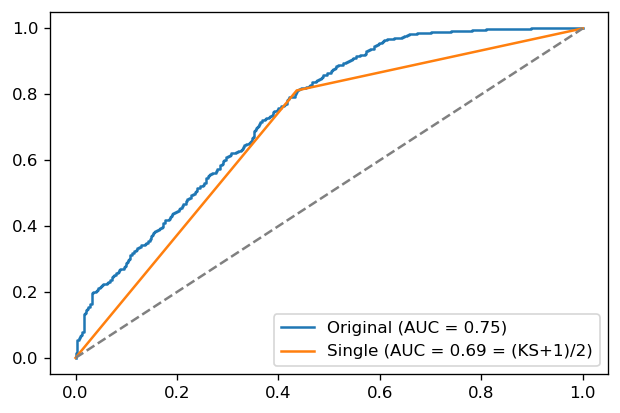

In [14]:
single_point_classifier(y_test, y_test_pred)

This result is not hard to prove: it is geometry on the triangle generated by the single-point classifier. Its height relative to the diagonal is $KS/\sqrt 2$ and the base is $\sqrt 2$. The calculation is then straightforward.

## Useful functions: model diagnostic with ROC, PR and KS

In [15]:
def roc_ks_ap(y_true, y_probs):

    from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score, roc_auc_score

    fig, ax = plt.subplots(ncols=2, figsize=(8,4)
                          )
    # ROC AUC
    fpr, tpr, thresh = roc_curve(y_true, y_probs)
    auc = roc_auc_score(y_true, y_probs)
    ax[0].plot(fpr, tpr, label='AUC = {0:.2f}'.format(auc))
    ax[0].plot([0,1], linestyle='--', color='gray')

    # KS
    youden = np.abs(tpr-fpr)
    optimal = np.argmax(youden)
    ks, opt_thresh = youden[optimal], thresh[optimal]
    ax[0].vlines(fpr[optimal], fpr[optimal], tpr[optimal], linestyle='--',
            color='gray',
            label='$\lambda = $ {0:.2f} (KS = {1:.2f})'.format(opt_thresh, ks))
    ax[0].legend(); ax[0].set_title("ROC curve")

    # PR
    prec, rec, _ = precision_recall_curve(y_true, y_probs)
    ap = average_precision_score(y_true, y_probs)
    ax[1].plot(rec, prec, label='Av. Prec. = {0:.2f}'.format(ap))
    ax[1].legend(); ax[1].set_title("PR curve")
    
    plt.tight_layout()
    plt.show()

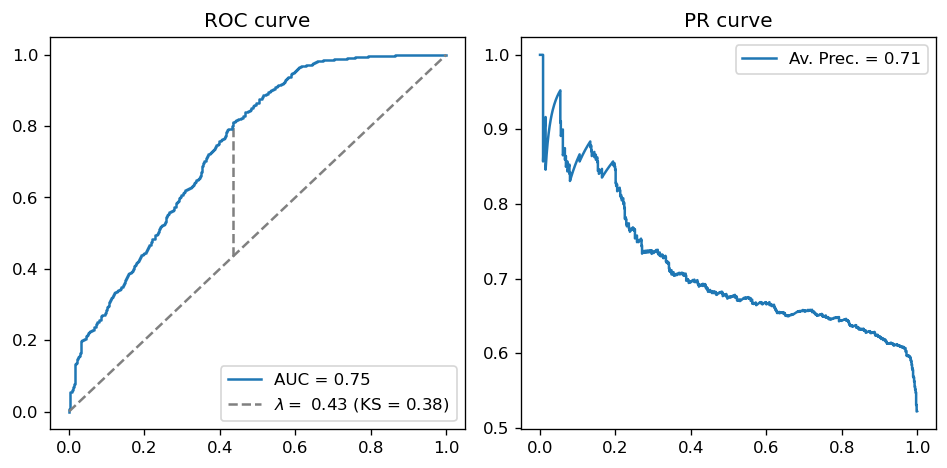

In [16]:
roc_ks_ap(y_test, y_test_pred)

## Imbalanced datasets

What happens to the KS score when faced with high class imbalance?

In [17]:
X, y = make_imbalanced_problem()
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=12)

We will train two random forest classifiers:
* Naive one, with no startegy against class imbalance
* One with balanced class weights to account for the class imbalance

We will want to measure slight noises that will appear due to the random nature of random forests. Because of that, we will actually create **many different random forests**, just changing the random seed `random_state`, and average over. This should give us a measure of error on the metrics we calculate, and help us understand which differences are significative and which are not.

### Naive model

In [18]:
from tqdm.notebook import tqdm

class ManyRFs:
    
    def __init__(self, n_seeds=50, *args, **kwargs):
        
        self.models = [RandomForestClassifier(*args, **kwargs, random_state=i)
                      for i in range(n_seeds)]
        self.n_seeds = n_seeds
    
    def fit(self, X, y):
        
        self.models = [model.fit(X, y) for model in tqdm(self.models)]
    
    def predict_proba(self, X):
        return np.array([model.predict_proba(X)[:,1] for model in self.models])

In [19]:
def average_results(y_true, probs):
    
    from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score, precision_recall_curve
    fig, ax = plt.subplots(figsize=(10,5), ncols=2)

    fpr_list, tpr_list, rec_list, prec_list = [], [], [], []
    auc_list, ks_list, thresh_list, ap_list = [], [], [], []
    for y_probs in probs:

        # ROC
        fpr, tpr, thresh = roc_curve(y_true, y_probs)
        auc = roc_auc_score(y_true, y_probs)

        # KS
        youden = np.abs(tpr-fpr); optimal = np.argmax(youden)
        ks, opt_thresh = youden[optimal], thresh[optimal]

        # PR
        prec, rec, _ = precision_recall_curve(y_true, y_probs)
        ap = average_precision_score(y_true, y_probs)
        
        # updates
        fpr_list.append(fpr); tpr_list.append(tpr); auc_list.append(auc); 
        ks_list.append(ks); thresh_list.append(opt_thresh)
        rec_list.append(rec); prec_list.append(prec); ap_list.append(ap)

        ax[0].plot(fpr, tpr, alpha=10/len(probs), color='blue')
        #ax[0].vlines(fpr[optimal], fpr[optimal], tpr[optimal], alpha=10/len(probs), color='black')
        ax[1].plot(rec, prec, alpha=10/len(probs), color='orange')


    roc = "ROC: AUC={0:.2f}$\pm${1:.2f}".format(np.mean(auc_list), np.std(auc_list))
    ks  = "KS = {0:.2f}$\pm${1:.2f} @ $\lambda$ = {2:.2f}$\pm${3:.2f}".format(
        np.mean(ks_list), np.std(ks_list), np.mean(thresh_list), np.std(thresh_list))
    pr = "PR: AP={0:.2f}$\pm${1:.2f}".format(np.mean(ap_list), np.std(ap_list))
    
    ax[0].set_title(roc + "\n" + ks)
    ax[1].set_title(pr)
    ax[0].plot([0,1], linestyle='--', color='gray')
    plt.suptitle(f"ROC, KS and PR results for {len(probs)} different seeds")
    plt.tight_layout()
    plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

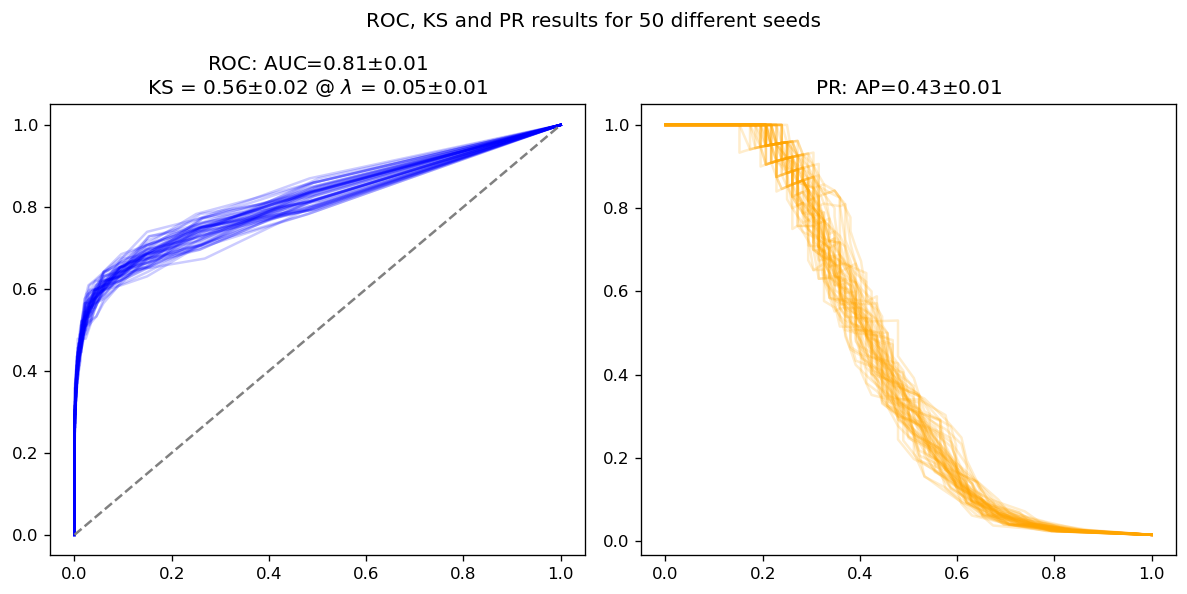

In [20]:
rfs = ManyRFs(n_jobs=-1)
rfs.fit(X_train, y_train)

probs = rfs.predict_proba(X_test)
average_results(y_test, probs)

As we can see, all metrics (ROC AUC, AP and KS) show an error of about 1-2 percentage points in this model. 
Let's see if adding class weights improves anything.

### Model adapted to imbalanced data

  0%|          | 0/50 [00:00<?, ?it/s]

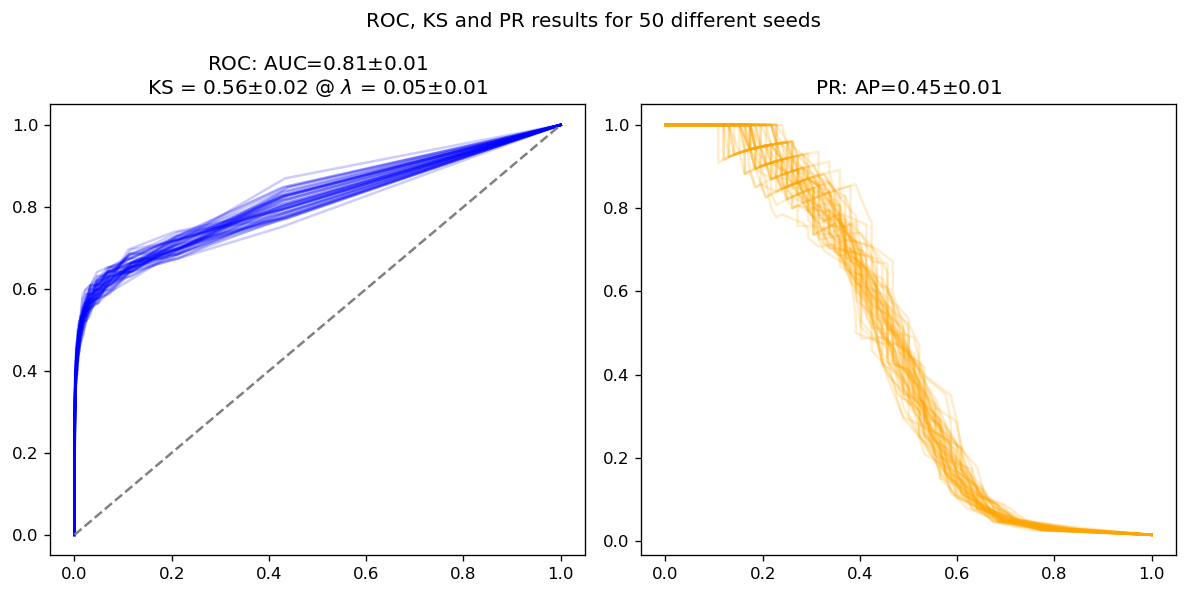

In [21]:
rfs_adap = ManyRFs(n_jobs=-1, class_weight='balanced')
rfs_adap.fit(X_train, y_train)

probs_adap = rfs_adap.predict_proba(X_test)
average_results(y_test, probs_adap)

We see interesting things happening:
* Within the error bars, both models have the same ROC AUC and KS; **this is expected**, since both AUC and KS depend only on the ROC curve, which itself is invariant under changes in class imbalance
* There are more differences in average precision and in the PR curve as whole; this is expected too. The model adapted to imbalance performs slightly better (around 2 sigma away from the naive model), but still close enough

In other words: KS is not heavily affected by class imbalance, since it depends on the ROC curve and it itself is mostly robust to imbalance.

## Conclusions

* We have presented the KS score as it is used to evaluate classification models (particularly credit)
* We have show that it has a deep connection with the ROC curve: it is the maximum vertical distance between the ROC curve and the $y=x$ diagonal
* This mechanism can be used to find an optimal threshold (if desired) for our score function, since it is where both curves (CDFs) are further apart from each other
* There is a weak connection between KS and ROC AUC. KS itself is blind to the original score's ROC AUC, but it is equal (up to some constants) to the ROC AUC of a new simplified classifier. 